В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------

### Imports

In [1]:
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from sklearn.dummy import DummyClassifier

pd.set_option('display.max_columns', 100)

### 0. Download the dataset
Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

In [2]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2'
data_dir = './data'

In [9]:
od.download(dataset_url, data_dir)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading bank-customer-churn-prediction-dlu-course-c-2.zip to ./data\bank-customer-churn-prediction-dlu-course-c-2


100%|██████████| 637k/637k [00:00<00:00, 1.02MB/s]



Extracting archive ./data\bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./data\bank-customer-churn-prediction-dlu-course-c-2


In [2]:
data_dir_path = './data/bank-customer-churn-prediction/'

In [12]:
os.rename('./data/bank-customer-churn-prediction-dlu-course-c-2',
          data_dir_path)

### 1. Read the data
Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [3]:
os.listdir('./data')

['bank-customer-churn-prediction',
 'cars.csv',
 'credit',
 'customer_segmentation_train.csv',
 'estimation_of_obesity_levels_based_on_eating_habits_and_physical.csv',
 'medical-charges.csv',
 'regression_data.csv']

In [4]:
raw_train_df = pd.read_csv(data_dir_path + 'train.csv')

In [15]:
raw_train_df.shape

(15000, 14)

In [16]:
raw_train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [17]:
raw_train_df['Exited'].value_counts()

Exited
0.0    11948
1.0     3052
Name: count, dtype: int64

In [5]:
train_df, val_df = train_test_split(raw_train_df,
                                    test_size=0.2,
                                    stratify=raw_train_df['Exited'],
                                    random_state=24)

In [19]:
print(f"train_df.shape: {train_df.shape}")
print(f"val_df.shape: {val_df.shape}")

train_df.shape: (12000, 14)
val_df.shape: (3000, 14)


### 2. Create inputs and targets
Визначить назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [6]:
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'

In [21]:
list(train_df.columns)[2:-1]

['Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [7]:
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

### 3. Identify numeric and categorical columns
Визначить з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [8]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [25]:
print(f'Numeric columns: {numeric_cols}')
print(f'Categorical columns: {categorical_cols}')

Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Surname', 'Geography', 'Gender']


### 4. Preprocessing
Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти передобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка має бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значень з `train_inputs`, `val_inputs` використовуючи `display()`.

In [26]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


There are no missing values in our dataset, so we do not need to use any imputer.

#### Scaling of the numeric columns

In [27]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.77,37.74,5.03,42613.83,1.59,0.79,0.49,117346.35
std,72.07,8.21,2.78,59698.76,0.53,0.41,0.50,45811.01
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,602.00,32.00,3.00,0.00,1.00,1.00,0.00,82867.55
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,122925.44
75%,709.00,42.00,7.00,109052.04,2.00,1.00,1.00,156628.86
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


The numeric columns in our dataset have varying ranges.

Let's use `MinMaxScaler` for scaling to range (0, 1).

In [9]:
scaler = MinMaxScaler().fit(train_inputs[numeric_cols]).set_output(transform='pandas')

In [11]:
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs[numeric_cols])

Now we can check if values in each column are in range (0, 1).

In [30]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.54,0.35,0.50,0.20,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.28,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.41
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.61
75%,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [12]:
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs[numeric_cols])

#### Encoding of the categorical columns

In [13]:
train_inputs[categorical_cols].describe()

,Surname,Geography,Gender
count,12000,12000,12000
unique,731,3,2
top,Ch'iu,France,Male
freq,211,7227,6817


##### `Gender`

In [33]:
train_inputs.Gender.value_counts(normalize=True).round(3)

Gender
Male      0.568
Female    0.432
Name: proportion, dtype: float64

In [34]:
val_inputs.Gender.value_counts(normalize=True).round(3)

Gender
Male      0.571
Female    0.429
Name: proportion, dtype: float64

For the `Gender` column let's use one-hot encoding bit with only one column.

In [14]:
gender_column = ['Gender']
gender_encoder = (OneHotEncoder(drop='first',
                                sparse_output=False,
                                handle_unknown='ignore')
                                .fit(train_inputs[gender_column])
                                .set_output(transform='pandas'))

In [15]:
gender_encoded_cols = list(gender_encoder.get_feature_names_out())
gender_encoded_cols

['Gender_Male']

In [17]:
train_inputs.loc[:, gender_encoded_cols] = gender_encoder.transform(train_inputs[gender_column])
val_inputs.loc[:, gender_encoded_cols] = gender_encoder.transform(val_inputs[gender_column])

##### `Geography`

In [38]:
train_inputs.Geography.value_counts(normalize=True)

Geography
France     0.602250
Spain      0.219917
Germany    0.177833
Name: proportion, dtype: float64

In [39]:
val_inputs.Geography.value_counts(normalize=True)


Geography
France     0.601667
Spain      0.221333
Germany    0.177000
Name: proportion, dtype: float64

Let's use `OneHotEncoder` for the `Geography` column.

In [18]:
geography_column = ['Geography']

geography_encoder = (OneHotEncoder(sparse_output=False,
                                   handle_unknown='ignore')
                     .fit(train_inputs[geography_column])
                     .set_output(transform='pandas'))

In [19]:
geography_encoded_cols = list(geography_encoder.get_feature_names_out())
geography_encoded_cols

['Geography_France', 'Geography_Germany', 'Geography_Spain']

In [20]:
train_inputs.loc[:, geography_encoded_cols] = geography_encoder.transform(train_inputs[geography_column])
val_inputs.loc[:, geography_encoded_cols] = geography_encoder.transform(val_inputs[geography_column])

##### `Surname`

In [21]:
train_inputs['Surname'].value_counts().sort_values(ascending=False)[:20]

Surname
Ch'iu          211
Ch'ang         191
Ch'ien         189
Hsia           172
T'ien          149
Hsueh          134
Ch'in          130
Maclean        118
Shih           117
Hs?            116
Kao            116
Chiu           114
Mazzanti       113
Chiang         110
H?             108
P'eng          106
Ch'eng         106
Ts'ui           97
Tien            90
Chukwuemeka     90
Name: count, dtype: int64

In [22]:
raw_train_df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [23]:
raw_train_df.CustomerId.nunique()

6348

In [24]:
raw_train_df.Surname.nunique()

764

In [25]:
(raw_train_df
 .groupby(['Surname'])['CustomerId']
 .count()
 .reset_index()
 .rename(columns={'CustomerId': 'cnt_CustomerId'})
 .sort_values('cnt_CustomerId', ascending=False))

,Surname,cnt_CustomerId
73,Ch'iu,252
71,Ch'ien,241
68,Ch'ang,225
295,Hsia,204
657,T'ien,187
...,...,...
50,Brownells,1
53,Bufkin,1
758,Zikoranachukwudimma,1
2,Aiken,1


In [26]:
unique_top_surname = (train_inputs['Surname']
                      .value_counts()
                      .sort_values(ascending=False)[:20]
                      .index.to_list())
unique_top_surname

["Ch'iu",
 "Ch'ang",
 "Ch'ien",
 'Hsia',
 "T'ien",
 'Hsueh',
 "Ch'in",
 'Maclean',
 'Shih',
 'Hs?',
 'Kao',
 'Chiu',
 'Mazzanti',
 'Chiang',
 'H?',
 "P'eng",
 "Ch'eng",
 "Ts'ui",
 'Tien',
 'Chukwuemeka']

In [27]:
train_inputs[train_inputs['Surname'].isin(unique_top_surname)]

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
6114,Ch'iu,-1.027181,Spain,Female,-0.315689,0.01,0.000000,-0.222222,1.0,0.0,-0.000054,0.0,0.0,0.0,1.0
8224,Chiu,-1.027039,France,Female,-0.314732,0.02,0.000000,-0.222222,1.0,1.0,-0.000054,0.0,1.0,0.0,0.0
7322,Ch'ang,-1.027569,France,Female,-0.317283,0.04,0.000003,-0.333333,1.0,0.0,-0.000056,0.0,1.0,0.0,0.0
1144,P'eng,-1.027911,France,Male,-0.315370,0.04,0.000000,-0.222222,1.0,1.0,-0.000053,1.0,1.0,0.0,0.0
2576,Hsueh,-1.027768,France,Male,-0.317921,0.00,0.000003,-0.333333,1.0,1.0,-0.000054,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10741,Ch'ien,-1.027233,France,Male,-0.311224,0.02,0.000000,-0.222222,1.0,1.0,-0.000055,1.0,1.0,0.0,0.0
6492,T'ien,-1.026686,France,Male,-0.315689,0.05,0.000002,-0.333333,0.0,0.0,-0.000056,1.0,1.0,0.0,0.0
2306,Hsia,-1.027637,France,Male,-0.314094,0.08,0.000000,-0.333333,1.0,0.0,-0.000054,1.0,1.0,0.0,0.0
583,T'ien,-1.027705,France,Male,-0.319515,0.08,0.000000,-0.222222,1.0,1.0,-0.000055,1.0,1.0,0.0,0.0


In [28]:
def bi_cat_countplot(df, column, hue_column, top=10):
    top_unique_hue_values = (df[hue_column]
                             .value_counts()
                             .sort_values(ascending=False)[:top]
                             .index.to_list())
    df_top_hue = df[df[hue_column].isin(top_unique_hue_values)]
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df_top_hue.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack().plot.bar(ax=ax, title=pltname)

    # value annotation in barplot
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

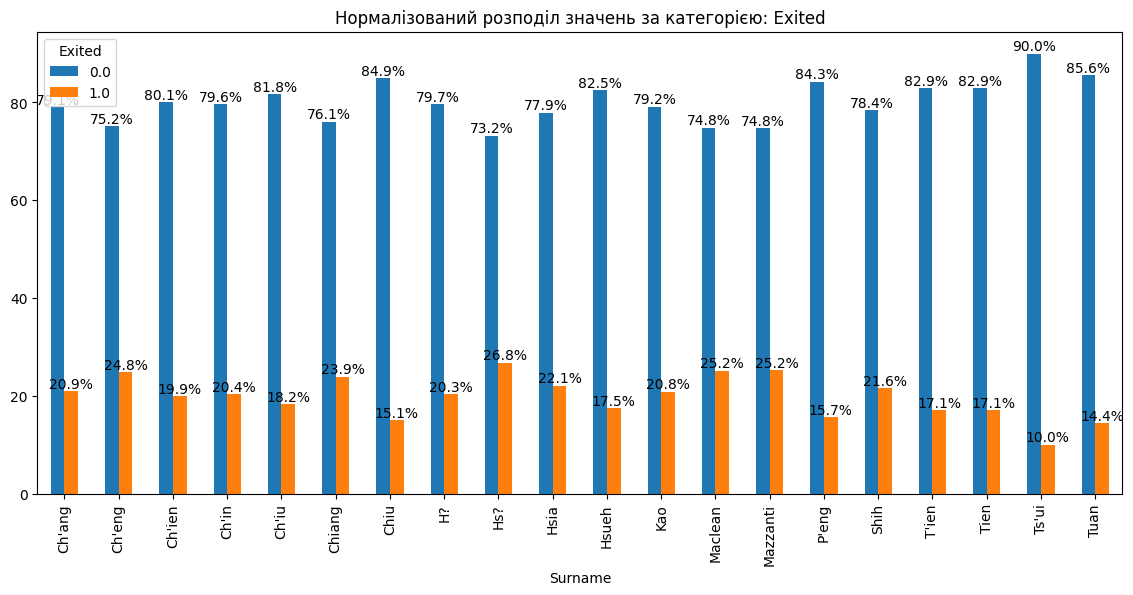

In [29]:
bi_cat_countplot(raw_train_df, 'Exited', 'Surname', top=20)

For the first attempt let's do not use the `Surname` column.

### 5. Save processed data to disk
Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [30]:
train_inputs.to_parquet(data_dir_path + 'train_inputs.parquet')
pd.DataFrame(train_targets).to_parquet(data_dir_path + 'train_targets.parquet')

val_inputs.to_parquet(data_dir_path + 'val_inputs.parquet')
pd.DataFrame(val_targets).to_parquet(data_dir_path + 'val_targets.parquet')

In [31]:
os.listdir(data_dir_path)

['first_prediction.JPG',
 'log_reg.joblib',
 'sample_submission.csv',
 'submission_log_reg.csv',
 'test.csv',
 'train.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

### 6. Create and train the model
З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [32]:
train_inputs.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
9741,Atherton,-1.027261,Spain,Male,-0.316645,0.09,0.000000,-0.222222,1.0,0.0,-0.000055,1.0,0.0,0.0,1.0
1161,Chukwuhaenye,-1.027666,France,Male,-0.319834,0.03,0.000000,-0.222222,1.0,1.0,-0.000056,1.0,1.0,0.0,0.0
6114,Ch'iu,-1.027181,Spain,Female,-0.315689,0.01,0.000000,-0.222222,1.0,0.0,-0.000054,0.0,0.0,0.0,1.0
14137,Chidiebere,-1.026959,Germany,Male,-0.317602,0.10,0.000003,-0.222222,1.0,1.0,-0.000056,1.0,0.0,1.0,0.0
10960,Nwankwo,-1.027079,Germany,Male,-0.316008,0.05,0.000003,-0.222222,1.0,0.0,-0.000056,1.0,0.0,1.0,0.0


In [33]:
feat_columns = numeric_cols + gender_encoded_cols + geography_encoded_cols
X_train = train_inputs[feat_columns]
X_val = val_inputs[feat_columns]

In [34]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (12000, 12)
X_val shape: (3000, 12)


In [35]:
model = (LogisticRegression(solver='liblinear',
                            random_state=24)
         .fit(X_train, train_targets))

### 7. Evaluate on validation and test set
Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якість моделі? Вона хороша, погана, задовільна?

In [36]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"AUROC for {name}: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='chocolate', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve for {name}")
    plt.legend(loc='lower right')
    plt.show()


def predict_and_plot(inputs, targets, name=''):
    # Prediction
    preds = model.predict(inputs)

    # Compute f1 score
    f1 = f1_score(targets, preds)
    print(f"F1 score for {name}: {f1 * 100:.2f}%")

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    cm = confusion_matrix(targets, preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap='YlOrBr')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Compute AUROC and plot the ROC curve
    compute_auroc_and_build_roc(inputs, targets, name)

    return preds

F1 score for Train: 33.69%


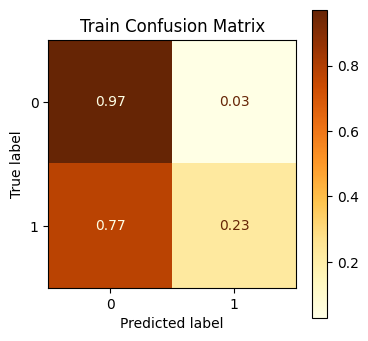

AUROC for Train: 0.80


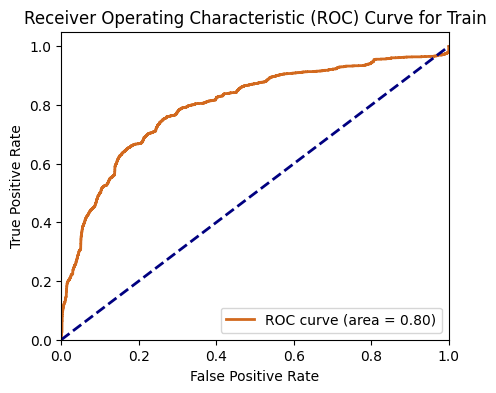

F1 score for Validation: 61.82%


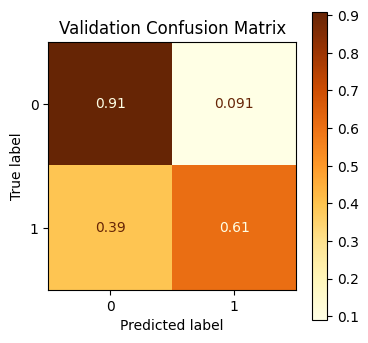

AUROC for Validation: 0.83


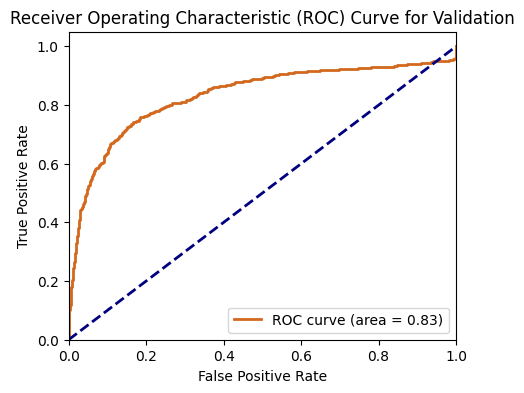

In [37]:
train_preds = predict_and_plot(X_train, train_targets, name='Train')
val_preds = predict_and_plot(X_val, val_targets, name='Validation')

The model performs better on the training set that on the validation set:
- F1 score: 63.89% on the training set and 60.94% on the validation set.
- AUROC: 0.88 on the training set and 0.87 on the validation set.

The model provides good predictions for the negative class (96%) and satisfactory predictions for the positive class (54% on the training set and 51% on the validation set).

### 8. Model that always predicts the majority class
Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть висновок про якість нашої моделі: якість хороша, погана, задовільна?

In [38]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, train_targets)

train_preds_dummy = dummy_model.predict(X_train)
val_preds_dummy = dummy_model.predict(X_val)


def compute_accuracy(y_true, y_pred, name=''):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy score on {name}: {accuracy * 100:.2f}%")

In [39]:
compute_accuracy(train_targets, train_preds_dummy, name='Training for dummy model')
compute_accuracy(val_targets, val_preds_dummy, name='Validation for dummy model')

compute_accuracy(train_targets, train_preds, name='Training for model')
compute_accuracy(val_targets, val_preds, name='Validation for model')


Accuracy score on Training for dummy model: 79.65%
Accuracy score on Validation for dummy model: 79.67%
Accuracy score on Training for model: 81.89%
Accuracy score on Validation for model: 84.77%


Our model performs slightly better than the dummy model that always predicts the majority class (87% accuracy vs. 80%).

### 9. Saving and loading trained models
Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [40]:
churn_prediction = {
    'model': model,
    'scaler': scaler,
    'gender_encoder': gender_encoder,
    'geography_encoder': geography_encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'gender_column': gender_column,
    'geography_column': geography_column,
    'gender_encoded_cols': gender_encoded_cols,
    'geography_encoded_cols': geography_encoded_cols
}

In [41]:
joblib.dump(churn_prediction, data_dir_path + 'log_reg.joblib')

['./data/bank-customer-churn-prediction/log_reg.joblib']

In [42]:
model_2 = joblib.load(data_dir_path + 'log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [53]:
def predict_raw_df(scaler, gender_encoder, geography_encoder,
                   numeric_cols, gender_column, geography_column,
                   gender_encoded_cols, geography_encoded_cols,
                   input_df: pd.DataFrame):
    input_df.loc[:, numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df.loc[:, gender_encoded_cols] = gender_encoder.transform(input_df[gender_column])
    input_df.loc[:, geography_encoded_cols] = geography_encoder.transform(input_df[geography_column])
    X_input = input_df[numeric_cols + gender_encoded_cols + geography_encoded_cols]
    prob = model.predict_proba(X_input)[:, 1]
    return prob

In [54]:
predict_raw_df(scaler, gender_encoder, geography_encoder,
               numeric_cols, gender_column, geography_column,
               gender_encoded_cols, geography_encoded_cols,
               raw_train_df[:5])

array([3.35876680e-04, 1.83866637e-02, 6.73891882e-03, 1.11717006e-01,
       9.58945317e-01])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [45]:
test_raw_df = pd.read_csv(data_dir_path + 'test.csv')

In [47]:
test_preds_proba = predict_raw_df(scaler, gender_encoder, geography_encoder,
                                  numeric_cols, gender_column, geography_column,
                                  gender_encoded_cols, geography_encoded_cols,
                                  test_raw_df)

In [48]:
test_raw_df['Exited'] = test_preds_proba

12. Зчитайте файл 'sample_submission.csv' і заповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профілю натиснувши `Submit Prediction`.

In [49]:
sample_submission = pd.read_csv(data_dir_path + 'sample_submission.csv')

In [50]:
sample_submission

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5
...,...,...
9995,24995,0.5
9996,24996,0.5
9997,24997,0.5
9998,24998,0.5


In [51]:
submission_log_reg = sample_submission[['id']].merge(test_raw_df[['id', 'Exited']], on='id')
submission_log_reg[:5]

,id,Exited
0,15000,0.268130
1,15001,0.007009
2,15002,0.030739
3,15003,0.327225
4,15004,0.008661


In [52]:
submission_log_reg.to_csv(data_dir_path + 'submission_log_reg.csv', index=False)